# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import os
import cv2
import datetime
import numpy as np
import random as rn
import tensorflow as tf
from keras import backend as K

try:
    from scipy.misc import imread
except:
    from imageio.v2 import imread

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
rn.seed(30)
try:
    tf.set_random_seed(30)
except:
    tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

train_doc = np.random.permutation(open('./data/train.csv').readlines())
val_doc = np.random.permutation(open('./data/val.csv').readlines())
 
batch_size = 10 #experiment with the batch size
data_dir = 'data'
train_path = f'{data_dir}/train'
val_path = f'{data_dir}/val'

### CONSTANT

In [4]:
#  Constant
TOTAL_IMAGE = 30
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 160
CHANNELS = 3
NUM_CLASSES = 5 # number of classes
INPUT_SHAPE=(TOTAL_IMAGE, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def crop_resize_img(img):
    resized_image = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
    return resized_image

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(TOTAL_IMAGE))
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, TOTAL_IMAGE, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, NUM_CLASSES)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = crop_resize_img(image)
                    temp = temp/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size, TOTAL_IMAGE, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, NUM_CLASSES)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = crop_resize_img(image)
                    temp = temp/255 #Normalize data
                                        
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

num_batches = len(np.random.permutation(train_doc)) // batch_size
print ('# num train batches =', num_batches)

num_batches = len(np.random.permutation(val_doc)) // batch_size
print ('# num val batches =', num_batches)


# training sequences = 663
# validation sequences = 100
# epochs = 30
# num train batches = 66
# num val batches = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras import optimizers
from keras.models import Sequential, Model
from keras.applications import ResNet152V2
from keras.layers import Conv3D, MaxPooling3D, Dropout, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, GlobalAveragePooling2D

### Standard CNN + RNN model with TimeDistributed + ResNet152V2

In [8]:
resnet_model = Sequential()
pre_trained_model = ResNet152V2(weights='imagenet', include_top=False)
resnet_model.add(TimeDistributed(pre_trained_model, input_shape=INPUT_SHAPE, name='ResNet152V2', trainable=False))
resnet_model.add(TimeDistributed(GlobalAveragePooling2D()))
resnet_model.add(TimeDistributed(Dense(64, activation='relu')))
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(GRU(128, return_sequences=True))
resnet_model.add(BatchNormalization())
resnet_model.add(Flatten())
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dense(NUM_CLASSES, activation='softmax'))

2024-04-01 22:32:39.240223: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-01 22:32:39.240245: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-01 22:32:39.240251: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-01 22:32:39.240285: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-01 22:32:39.240301: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 3D Convolutional Network model

In [9]:
model_conv3d = Sequential()

model_conv3d.add(Conv3D(8, kernel_size=(3,3,3), input_shape=INPUT_SHAPE, padding='same'))
model_conv3d.add(Activation('relu'))
model_conv3d.add(Dropout(0.25))

model_conv3d.add(MaxPooling3D(pool_size=(2,2,2)))

model_conv3d.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model_conv3d.add(Activation('relu'))

model_conv3d.add(MaxPooling3D(pool_size=(2,2,2)))

model_conv3d.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model_conv3d.add(Activation('relu'))

model_conv3d.add(MaxPooling3D(pool_size=(2,2,2)))

model_conv3d.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model_conv3d.add(Activation('relu'))
model_conv3d.add(Dropout(0.25))

model_conv3d.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_conv3d.add(Flatten())

model_conv3d.add(Dense(256, activation='relu'))

model_conv3d.add(Dense(128, activation='relu'))
model_conv3d.add(Dropout(0.5))

#softmax layer
model_conv3d.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam() #write your optimizer
model_conv3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_conv3d.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 8)   656       
                                                                 
 activation (Activation)     (None, 30, 160, 160, 8)   0         
                                                                 
 dropout (Dropout)           (None, 30, 160, 160, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 80, 80, 8)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 16)    3472      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 16)    0         
                                                      

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
optimiser = optimizers.Adam() #write your optimizer

In [11]:
resnet_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(resnet_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ResNet152V2 (TimeDistribut  (None, 30, 5, 5, 2048)    58331648  
 ed)                                                             
                                                                 
 time_distributed (TimeDist  (None, 30, 2048)          0         
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 30, 64)            131136    
 stributed)                                                      
                                                                 
 dense_1 (Dense)             (None, 30, 256)           16640     
                                                                 
 batch_normalization (Batch  (None, 30, 256)           1024      
 Normalization)                                         

Total params: 59613765 (227.41 MB)
Trainable params: 1281349 (4.89 MB)
Non-trainable params: 58332416 (222.52 MB)
_________________________________________________________________
None


In [12]:
model_conv3d.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_conv3d.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 8)   656       
                                                                 
 activation (Activation)     (None, 30, 160, 160, 8)   0         
                                                                 
 dropout (Dropout)           (None, 30, 160, 160, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 80, 80, 8)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 16)    3472      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 16)    0         
                                                      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

### Setup Experiment

In [14]:
curr_dt_time = datetime.datetime.now()

# Generate the experiment name
experiment_name = 'model_experiment' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
# Create folder
if not os.path.exists(experiment_name):
    os.mkdir(experiment_name)

# Generate file pattern
filepath = experiment_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Create model check point
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Reduce learning rate when a metric has stopped improving.
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='auto') # write the REducelronplateau code here

# Stop training when a monitored metric has stopped improving.
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

### Train and tuning ResNet model

In [16]:
resnet_history=resnet_model.fit(
    generator(train_path, train_doc, batch_size), 
    validation_data=generator(val_path, val_doc, batch_size), validation_steps=validation_steps,
    steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, class_weight=None,
    workers=1, initial_epoch=0, max_queue_size=3000
    )

Source path =  data/train ; batch size = 10
Epoch 1/30


2024-04-01 22:32:49.719129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-04-01 22:32:50.335714: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


67/67 [==============================] - ETA: 0s - loss: 5.6699 - categorical_accuracy: 0.3725Source path =  data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 3.74662, saving model to model_experiment_2024-04-0122_32_44.069473/model-00001-5.66993-0.37255-3.74662-0.44000.keras
67/67 [==============================] - 239s 3s/step - loss: 5.6699 - categorical_accuracy: 0.3725 - val_loss: 3.7466 - val_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 7.8931 - categorical_accuracy: 0.3980
Epoch 2: val_loss did not improve from 3.74662
67/67 [==============================] - 83s 1s/step - loss: 7.8931 - categorical_accuracy: 0.3980 - val_loss: 10.4405 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 7.2562 - categorical_accuracy: 0.3632
Epoch 3: val_loss did not improve from 3.74662
67/67 [==============================] - 81s 1s/step - loss: 7.256

<Figure size 1000x1000 with 0 Axes>

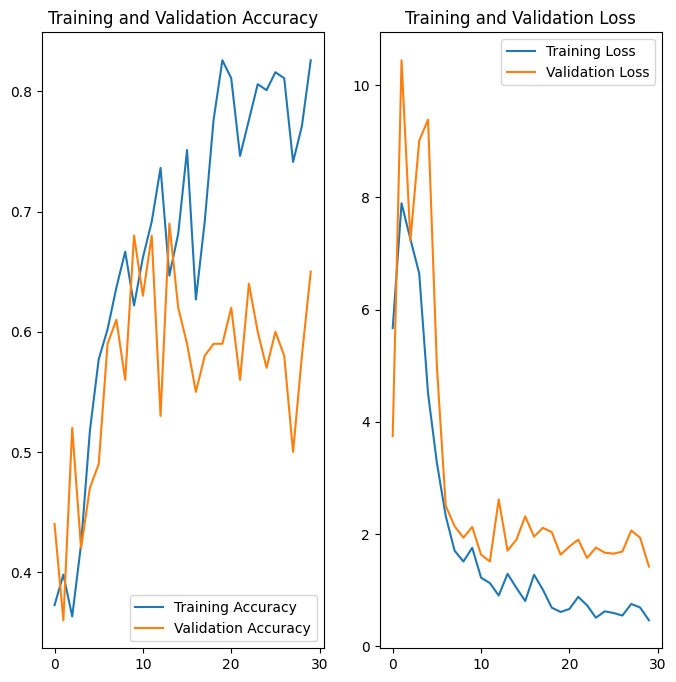

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (10,10))

acc = resnet_history.history['categorical_accuracy']

val_acc = resnet_history.history['val_categorical_accuracy']

loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Train and tuning 3D Convolutional Model

In [ ]:
history_conv3d=model_conv3d.fit(generator(train_path, train_doc, batch_size), steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=generator(val_path, val_doc, batch_size), 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (10,10))

acc = history_conv3d.history['categorical_accuracy']

val_acc = history_conv3d.history['val_categorical_accuracy']

loss = history_conv3d.history['loss']
val_loss = history_conv3d.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()